In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import qmc 
import scipy.special as special
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
X_res = scipy.io.loadmat('Data/X_Res.mat')
x_b = scipy.io.loadmat('Data/X_B.mat')
bounds = scipy.io.loadmat('Data/Boundary.mat')
ub,lb = bounds['ub'], bounds['lb']

Text(0.5, 1.0, 'Collocation Points')

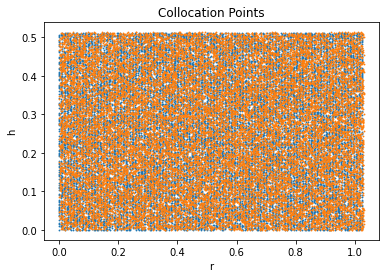

In [39]:
x_points, y_points = X_res['x_res'], X_res['y_res']
bc_left_x, bc_left_y = x_b['X_b_left'][:,0],  x_b['X_b_left'][:,1] 
bc_right_x, bc_right_y = x_b['X_b_right'][:,0],  x_b['X_b_right'][:,1] 
bc_up_x, bc_up_y = x_b['X_b_up'][:,0],  x_b['X_b_up'][:,1] 
bc_down_x, bc_down_y = x_b['X_b_down'][:,0],  x_b['X_b_down'][:,1] 

Nc = 20000 #number of collocation points
Nb = 100 #number of bc points

# LHS to generate points
def make_points(dimensions,tot_points):
    engine = qmc.LatinHypercube(d=dimensions)
    points = engine.random(n=tot_points)
    return points

collocation_points = make_points(dimensions=2,tot_points=Nc) 
x_points1, y_points1 = collocation_points[:,0]*1.03, collocation_points[:,1] * 0.513

# Plot the points
plt.scatter(x_points, y_points, s=0.7)
# plt.scatter(bc_left_x, bc_left_y, s=2)
# plt.scatter(bc_right_x, bc_right_y, s=2)
# plt.scatter(bc_up_x, bc_up_y, s=2)
# plt.scatter(bc_down_x, bc_down_y, s=2)
plt.scatter(x_points1, y_points1, s=0.7)
plt.xlabel('r')
plt.ylabel('h')


plt.title('Collocation Points')

In [4]:
#Analytical solution of the cylinderical problem, using bessel funcitons

sigma_a = 0.45
sigma_s = 2
sigma_f = 0.5
vsigma_f = 2.5
d = 0.714
D = 1/(3*(sigma_a+sigma_s))
B_g_square = (vsigma_f - sigma_a)/D
R_e_square = (np.pi**2 + 2.405**2) / B_g_square
R_e = R_e_square ** (1/2)
#R = R_e - d
H_e = R_e
AC = 1/special.jv(0,0)

def Exact_u_func(x,y):
    u = AC*special.jv(0,(2.405/R_e)*x)*np.cos((np.pi/H_e)*y)
    return u

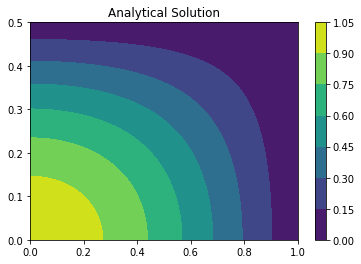

In [5]:
x_pred, y_pred = np.linspace(0,1,100), np.linspace(0,0.5,100)
X, Y = np.meshgrid(x_pred, y_pred)
x_p, y_p = X.flatten(), Y.flatten()
analytical_solution = Exact_u_func(x_p,y_p) 
plt.title('Analytical Solution')
plt.contourf(X,Y,analytical_solution.reshape(100,100),cmap='viridis')
plt.colorbar()

In [6]:
#funcs to make life easier
def data_loader(x,grad=True):
    x_tensor = torch.tensor(x,requires_grad=grad,dtype=torch.float32,device=device)
    return x_tensor

def rerange(X,upper_bound=data_loader(ub,False),lower_bound=data_loader(lb,False)):
    return 2 * (X-lower_bound) / (upper_bound-lower_bound) - 1

def diff_x(a,b,graph=True):
    da_db = torch.autograd.grad(a.sum(),b,create_graph=graph)[0]
    return da_db

In [7]:
class PINNs(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2,40)
        self.hid1 = nn.Linear(40,40)
        self.hid2 = nn.Linear(40,40)
        self.hid3 = nn.Linear(40,40)
        self.hid4 = nn.Linear(40,40)
        self.hid5 = nn.Linear(40,40)
        self.hid6 = nn.Linear(40,40)
        self.hid7 = nn.Linear(40,40)
        self.hid8 = nn.Linear(40,40)
        self.final = nn.Linear(40,1)
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
    def forward(self,x,y):
        X = torch.cat((x,y),1)
        X = rerange(X)
        act1 = torch.tanh(self.input(X))
        act2 = torch.tanh(self.hid1(act1))
        act3 = torch.tanh(self.hid2(act2))
        act4 = torch.tanh(self.hid3(act3))
        act5 = torch.tanh(self.hid4(act4))
        act6 = torch.tanh(self.hid5(act5))
        act7 = torch.tanh(self.hid6(act6))
        act8 = torch.tanh(self.hid7(act7))
        act9 = torch.tanh(self.hid8(act8))
        output = self.final(act9)
        return output

In [8]:
#turn all data used into tensor
x_phy,y_phy  = data_loader(x_points), data_loader(y_points)
x_left_bc, y_left_bc = data_loader(bc_left_x).unsqueeze(1), data_loader(bc_left_y.reshape(-1)).unsqueeze(1)
x_down_bc,y_down_bc = data_loader(bc_down_x.reshape(-1)).unsqueeze(1), data_loader(bc_down_y).unsqueeze(1)
x_top_bc, y_top_bc = data_loader(bc_up_x.reshape(-1),False).unsqueeze(1), data_loader(bc_up_y,False).unsqueeze(1)
x_right_bc,y_right_bc = data_loader(bc_right_x.reshape(-1),False).unsqueeze(1), data_loader(bc_right_y.reshape(-1),False).unsqueeze(1)
central_x_bc = data_loader([0],False).unsqueeze(1)
central_y_bc = data_loader([0],False).unsqueeze(1)

In [ ]:
t1 = time.time()
NN = PINNs().to(device)
lr = 1e-3
epochs = 5000
optimizer = torch.optim.Adam(params=NN.parameters(),lr=lr)
for i in range(epochs):
    optimizer.zero_grad()
    
    phi_pinns = NN(x_phy,y_phy) #for pde
    phi_left = NN(x_left_bc,y_left_bc) #neumann  bc
    phi_down = NN(x_down_bc,y_down_bc) #neumann bc
    phi_top = NN(x_top_bc,y_top_bc) # Dirichlet bc
    phi_right = NN(x_right_bc,y_right_bc) # Dirichlet bc
    phi_central = NN(central_x_bc,central_y_bc) #center
    
    phi_dx = diff_x(phi_pinns,x_phy)
    phi_d2x = diff_x(phi_dx,x_phy)
    phi_dy = diff_x(phi_pinns,y_phy)
    phi_d2y = diff_x(phi_dy,y_phy)
    
    eqn_pde = x_phy*(phi_d2x+phi_d2y + B_g_square*phi_pinns) + x_phy
    
    pde_loss = torch.sum(eqn_pde**2)
    
    neumann_left_bc = diff_x(phi_left,x_left_bc)
    neumann_down_bc = diff_x(phi_down,y_down_bc)
    
    bc_left_wall = torch.sum(neumann_left_bc**2)
    bc_down_wall = torch.sum(neumann_down_bc**2)
    bc_right_wall = torch.sum(phi_right**2)
    bc_top_wall = torch.sum(phi_top**2)
    
    bc_loss = bc_left_wall + bc_down_wall + bc_right_wall + bc_top_wall
    
    source_loss = torch.sum((phi_central-torch.ones_like(phi_central))**2)
    
    #can adjust weighs
    loss = pde_loss + bc_loss + source_loss
    
    if (i+1) % 100 ==0:
        print(f'Epochs [{i+1}/{epochs}, Total Loss: {loss.item():.8f}')
        print(f'time eclipsed {(time.time()-t1)} seconds')
        torch.save(NN.state_dict(),'PINNs.pth')
        
tot_time = (time.time() - t1)/60
print(f'tot simulation time {tot_time} minutes')

In [44]:
NN = PINNs()
#model_path = 'barkla_model_predictor.pth'
model_path = 'cylindrical_pinns.pth'
NN.load_state_dict(torch.load(model_path, map_location=device))
NN.eval()
NN.to(device)

RuntimeError: Error(s) in loading state_dict for PINNs:
	Missing key(s) in state_dict: "input.weight", "input.bias", "hid1.weight", "hid1.bias", "hid2.weight", "hid2.bias", "hid3.weight", "hid3.bias", "hid4.weight", "hid4.bias", "hid5.weight", "hid5.bias", "hid6.weight", "hid6.bias", "hid7.weight", "hid7.bias", "hid8.weight", "hid8.bias", "final.weight", "final.bias". 
	Unexpected key(s) in state_dict: "linear_layers.0.weight", "linear_layers.0.bias", "linear_layers.1.weight", "linear_layers.1.bias", "linear_layers.2.weight", "linear_layers.2.bias", "linear_layers.3.weight", "linear_layers.3.bias", "linear_layers.4.weight", "linear_layers.4.bias", "linear_layers.5.weight", "linear_layers.5.bias", "linear_layers.6.weight", "linear_layers.6.bias", "linear_layers.7.weight", "linear_layers.7.bias", "linear_layers.8.weight", "linear_layers.8.bias". 

In [42]:
pred = scipy.io.loadmat('Data/X_Pred.mat')
x_, y_ =  pred['x_pred'], pred['y_pred']
predict_x, predict_y = data_loader(x_,False).reshape(-1).unsqueeze(1), data_loader(y_,False).reshape(-1).unsqueeze(1)
with torch.no_grad():
    predictions = NN(predict_x, predict_y)
predictions_flattened = predictions.flatten()

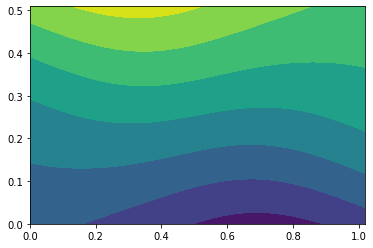

In [22]:
plt.contourf(predict_x.reshape(200,200),predict_y.reshape(200,200),predictions.reshape(200,200))

In [40]:
sum(x_points)

array([10264.21325636])

In [41]:
sum(x_points1)

10299.999323886796